# Analyze landfast ice - old

Import modules

In [2]:
import numpy as np 
import cartopy
import cartopy.crs as ccrs
import matplotlib
matplotlib.interactive(True)
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
from functions import trend, load_ice, plot_cartopy
from matplotlib import gridspec

# %matplotlib notebook

Load data

In [3]:
path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Read in data
nc = Dataset(path + region + '.nc', 'r')
lon = nc.variables['longitude'][600:1450,1700:]
lat = nc.variables['latitude'][600:1450,1700:]
juld = nc.variables['juld'][:]
land = nc.variables['land'][:][600:1450,1700:]
E_CT = nc.variables['E_CT'][:,600:1450,1700:]       

CT = np.nan*np.ones(E_CT.shape)
CT[E_CT==1] = 10
CT[E_CT==2] = 20
CT[E_CT==3] = 30
CT[E_CT==4] = 40
CT[E_CT==5] = 50
CT[E_CT==6] = 60
CT[E_CT==7] = 70
CT[E_CT==8] = 80
CT[E_CT==9] = 90
CT[E_CT==10] = 95
CT[E_CT==11] = 100


# Date time information
d0ord = date(1950,1,1).toordinal()
dt_ordinal = d0ord + juld
dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
months = [dates[tt].month for tt in range(len(juld))]
years = [dates[tt].year for tt in range(len(juld))]
months_unique = np.unique(months)
years_unique = np.unique(years)

### Get contour lines of land

In [4]:
# Convert to distance from degree. 1 degree lat = 110km. 1 degree lon = 111.320*cos(latitude) km.
def deg2km(lat,lon):
    u_km = lon*111*np.cos(lat)
    v_km = lat*111
    return abs(u_km), abs(v_km)

In [5]:
# Get land values
CS = plt.contour(lon, lat, land, levels=[0])
sina = CS.allsegs
sina = np.concatenate(np.concatenate(sina, axis=0))
landlon = sina[:,0]
landlat = sina[:,1]
# plt.plot(landlon,landlat,'.')
plt.clf()

<Figure size 432x288 with 0 Axes>

### Get contour lines of Sina

In [112]:
# Draw a coast line

coastlon=[]
coastlat=[]
years_sina=[]

n = 5 # group size of coastline points

for i in range(0, len(landlon), n):
    # find more eastward point of the coastline within the group 
    most_east_idx = np.where(landlon == np.nanmax(landlon[i:i + n]))
    coastlon.append(landlon[most_east_idx[0][0]])
    coastlat.append(landlat[most_east_idx[0][0]])

coastlon = np.array(coastlon)
coastlat = np.array(coastlat)

# Remove points in HB
coastlat = coastlat[coastlon>-64]
coastlon = coastlon[coastlon>-64]

# Sort by decreasing latitude
coastlat,coastlon = (np.array(t) for t in zip(*sorted(zip(coastlat,coastlon))))



# filter out weird points (MARCH)
# coastlon = np.concatenate((coastlon[12:20],coastlon[22:-1]))
# coastlat = np.concatenate((coastlat[12:20],coastlat[22:-1]))

#### Function for getting d_km (distance from coastline to Sina)

In [343]:
def dist_sina(mon,kk):
    
    # Choose which month of every year

    # x and y store the contour lines for each year (24 years)

    x=[]
    y=[]
    cnt=0
    for yr in years_unique:
        # Every year for the month defined by mon
        which = (years == yr) * (np.array(months) == mon)

        if np.sum(which) >= 1:
            # Only take the first day of the month for each year. Most years only have between 1 and 4 observational days.
            tt = np.where(which)[0][kk]
    #         Sina is contour where the concentration is 10/10
            CS = plt.contour(lon, lat, CT[tt,:,:], levels=[99.9])
            plt.clf()
            # allsegs gets the values of the contour line
            sina = CS.allsegs
            # Add condition for summer months, check if list is empty
            if len(sina[0]) > 0:
            
                sina = np.concatenate(np.concatenate(sina, axis=0))
                xarr = sina[:,0]
                yarr = sina[:,1]
        #         plt.plot(xarr,yarr,'.')

                transform = rot.transform_points(rot,xarr,yarr)
                x.append(transform[...,0])
                y.append(transform[...,1])
        cnt += 1

    ### Filter 

    X=[]
    Y=[]
    yrs=[]
    for i in range(len(x)):
        if np.nanmean(x[i]) < -60.5: # if the sina is the true sina (average lat is not greater than 60.5)
            X.append(x[i])
            Y.append(y[i])
            yrs.append(years_unique[i])

    # Manually filter out bad years
    if mon==1:
        bad_yrs = [1998, 1999, 2001, 2004, 2007, 2010] # January
    elif mon==2:
        bad_yrs = [2004, 2005] # February
    elif mon==3:  
        bad_yrs = [2008] # March
    elif mon==4:
        bad_yrs = [1999, 2008, 2010] # April
#     elif mon==5:
#         bad_yrs = [1999, 2002, 2006, 2009, 2010, 2011, 2018] # May

#     for yr in bad_yrs:
#         ind = np.where(np.array(yrs) == yr)[0][0]
#         X.pop(ind)
#         Y.pop(ind)
#         yrs.pop(ind)

    # Reduce domain

    sinalon_red=[]
    sinalat_red=[]
    years_sina = []
    for i in range(len(Y)):
        # Only plot within coastline domain and do not enter Hudson Bay
        inds = (np.where( (Y[i] > np.min(coastlat)) & (Y[i] < np.max(coastlat)) & (X[i] > -64) ))
        if len(inds[0]) > 0:
            sinalat_red.append(Y[i][inds])
            sinalon_red.append(X[i][inds])
            # Store years not filtered out
            years_sina.append(yrs[i])        

    ### Calculate distance between Sina and coastline        

    # interpolating on coastline
    m = len(years_sina)
    n = len(coastlat)
    d_km = np.zeros((m,n))

    for i in range(len(sinalon_red)):
        f = interp1d(sinalat_red[i],sinalon_red[i],kind='nearest',fill_value="extrapolate")

        u_km, v_km = deg2km(coastlat, f(coastlat) - coastlon)
    #     d_km.append(u_km)
        d_km[i,:] = u_km


    ### Calculate trends

    ytrend=np.zeros(np.shape(d_km)[1])
    #     dtrend_95=np.zeros(np.shape(d_km)[1])
    #     ybar=np.zeros(np.shape(d_km)[1])

    for i in range(np.shape(d_km)[1]):
        mean, tr, dt95 = trend(np.array(years_sina),d_km[:,i])
        ytrend[i] = tr
    #         dtrend_95[i] = dt95
    #         ybar[i] = mean


    return d_km, years_sina, ytrend, sinalat_red, sinalon_red

### Heatmap

<Figure size 432x288 with 0 Axes>

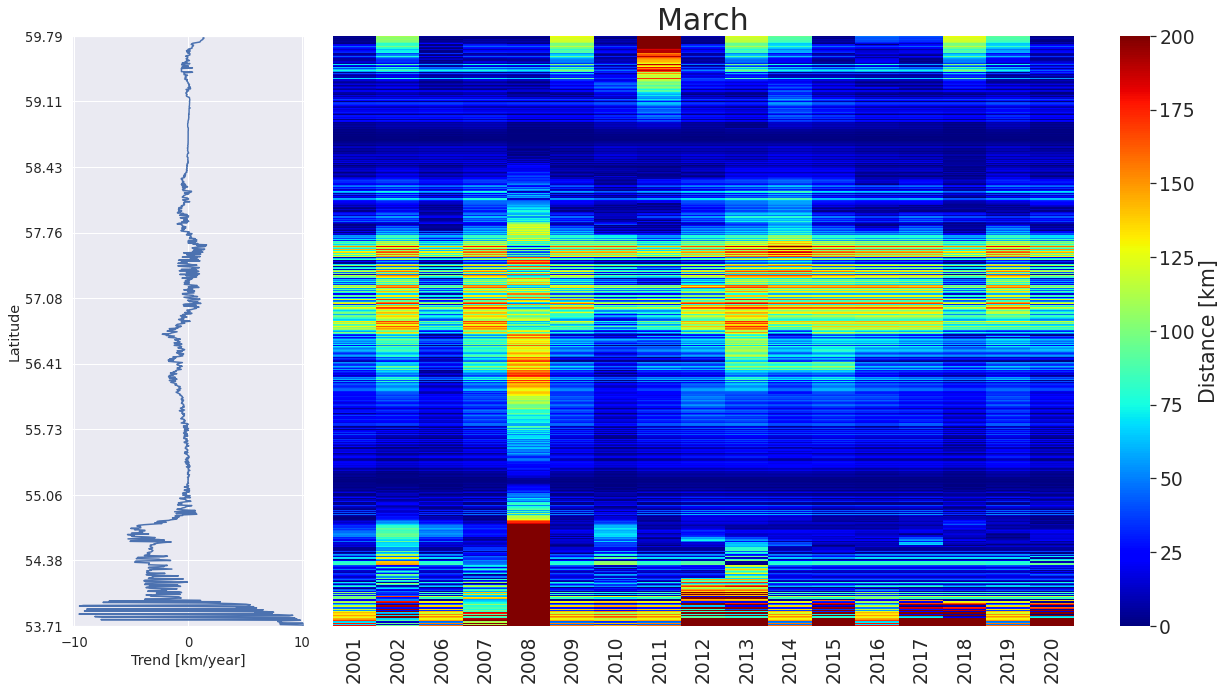

In [354]:
# Which months
mon = 3

d_km, years_sina, ytrend, sinalat_red, sinalon_red = dist_sina(mon,0)

# Plot which year
# i = 4
# plt.subplot(1,2,1)
fig = plt.figure(figsize=(18,10))
# Alter width ratios of subplots for trend plotting
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4]) 
ax = fig.add_subplot(gs[0])

# Plot trends
sns.set(font_scale=1.7)
plt.plot(ytrend,np.arange(0,len(ytrend)))
ytick_labels = np.round(np.linspace(coastlat[-1],coastlat[0],10),2)
plt.yticks(np.linspace(d_km.shape[1],0,10), ytick_labels)  # Set text labels and properties.
plt.xlabel('Trend [km/year]')
plt.ylabel('Latitude')
plt.ylim([0,d_km.shape[1]])
plt.xlim([-1*np.max(abs(ytrend)),np.max(abs(ytrend))])

# Plot heatmap
ax = fig.add_subplot(gs[1])

# Flip it so y axis increases with latitude
d_km_flip = np.array(d_km)
# Plot heatmap of distance
ax = sns.heatmap(d_km_flip.transpose(), cmap='jet', cbar_kws={'label': 'Distance [km]'}, vmin=0, vmax=200)
ax.invert_yaxis()
ax.set_yticks(np.linspace(d_km_flip.shape[1],0,10))
# ax.set_yticklabels(ytick_labels)
xtick_labels = years_sina
ax.set_xticklabels(xtick_labels,rotation='vertical')

# Only call set font scale once. to undo, call sns.reset_defaults()
# sns.set(font_scale=1.4)

cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=18)

# plt.ylabel('Latitude')
mon_str = ['January','February','March','April','May']
plt.title(mon_str[mon-1],fontsize=30)
plt.tight_layout()
# plt.savefig('/home/mwang/CIS-project/figures/May5_LF_May_heatmap+trend_manfilt')


### Compare interpolated Sina to true values

In [5]:
# plt.subplot(1,2,1)

fig = plt.figure(figsize=(12,15))
# fig = plt.figure()

# Compare different weeks of the month
d_km, years_sina, ytrend, sinalat_red0, sinalon_red0 = dist_sina(mon,kk=0)
d_km, years_sina, ytrend, sinalat_red, sinalon_red = dist_sina(mon,kk=-1)


for i in range(len(years_sina)):
    ax = fig.add_subplot(4,5,i+1, projection=rot)
    plot_cartopy(ax,lon,lat)

    # coastline
    ax.plot(coastlon, coastlat,'k.', transform=ccrs.PlateCarree(),zorder=4)
    f = interp1d(sinalat_red[i],sinalon_red[i],kind='nearest',fill_value="extrapolate")

#     Interpolated sina
    plt.plot(f(coastlat),coastlat,'.',transform=ccrs.PlateCarree(),zorder=4)

    # Actual sina
#     ax.plot(sinalon_red0[i],sinalat_red0[i],'.',transform=ccrs.PlateCarree(),zorder=4,label='ind=0')
    ax.plot(sinalon_red[i],sinalat_red[i],'.',transform=ccrs.PlateCarree(),zorder=4)

    plt.title(years_sina[i],fontsize=18)
    plt.tight_layout()
# plt.legend()
plt.show()
# plt.clf()

# plt.savefig('/home/mwang/CIS-project/figures/May5_LF_Febyears') 


    # Add gridlines
#     g = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                       linewidth=2, color='gray', alpha=0.5, linestyle='--',zorder=5,x_inline=False, y_inline=False)
#     g.ylabels_right = False
#     g.xlabels_top = False

NameError: name 'dist_sina' is not defined

<Figure size 864x1080 with 0 Axes>

### Plot Sina of all years on one map

Text(0.5, 1.0, 'Group size = 5')

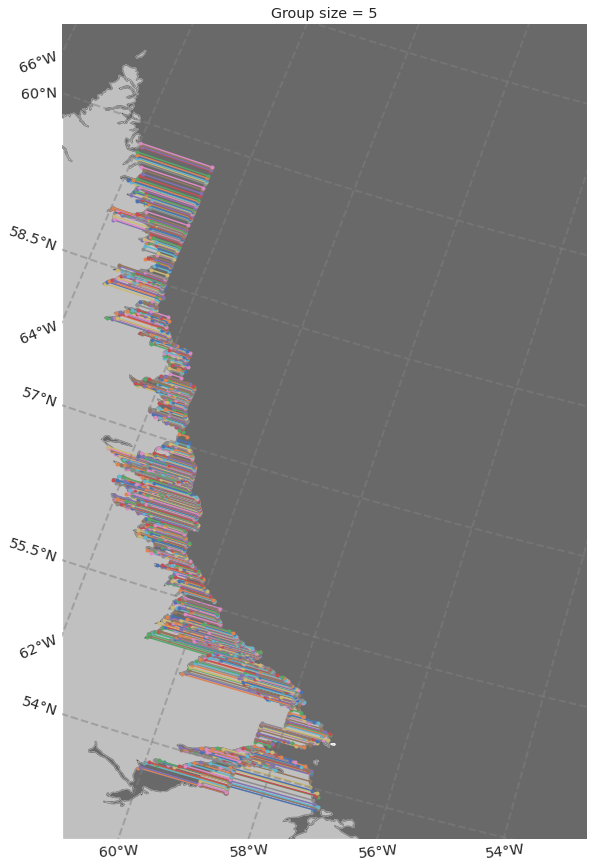

In [356]:
# Plot Sina of all years
sns.set(font_scale=1.2)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1, projection=rot)

plot_cartopy(ax, lon, lat)

# coastline
# ax.plot(coastlon, coastlat,'k.', transform=ccrs.PlateCarree(),zorder=4)

# for i in range(len(sinalat_red)):
#     ax.plot(sinalon_red[i],sinalat_red[i],'.',transform=ccrs.PlateCarree(),zorder=4,label=years_sina[i])    
# plt.legend()

i = np.where(np.array(years_sina)==2013)[0][0]
# ax.plot(sinalon_red[i],sinalat_red[i],'.',transform=ccrs.PlateCarree(),zorder=4,label=years_sina[i])    

##### See how distances are calculated

f = interp1d(sinalat_red[i],sinalon_red[i],kind='nearest',fill_value="extrapolate")

for i in range(len(coastlat)):
    plt.plot([coastlon[i], f(coastlat[i])],[coastlat[i], coastlat[i]],'.-',transform=ccrs.PlateCarree(),zorder=4)
# ax.plot(coastlon[150], coastlat[150],'ro', transform=ccrs.PlateCarree(),zorder=4)
# ax.plot(coastlon[-1], coastlat[-1],'ro', transform=ccrs.PlateCarree(),zorder=4)


#####

# March location of time series
# ax.plot(coastlon[tt], coastlat[tt],'r^', markersize=10,transform=ccrs.PlateCarree(),zorder=4)

# Add gridlines
g = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',zorder=5,x_inline=False, y_inline=False)
g.ylabels_right = False
g.xlabels_top = False
plt.title('Group size = 5')

# plt.clf()
# plt.title('April')
# plt.savefig('/home/mwang/CIS-project/figures/May5_LF_April') 

# Anomolies

Trendline isn't strait because time is not continuous. 


Text(0.5, 1.0, 'd_km anomolies (km)')

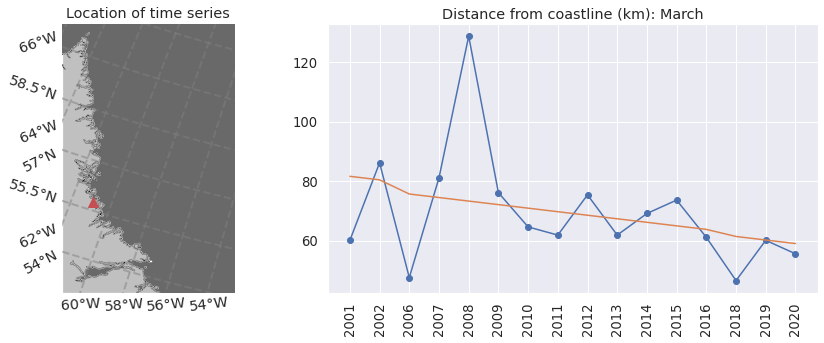

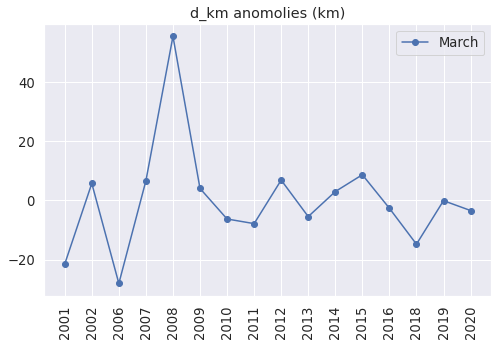

In [357]:
# Pick one location 
# sns.reset_defaults()

# Location on map
tt = 400
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
# ax = fig.add_subplot(1,2,1, projection=rot)
ax = fig.add_subplot(gs[0], projection=rot)
plot_cartopy(ax,lon,lat)

# coastline
ax.plot(coastlon[tt], coastlat[tt],'r^', markersize=10,transform=ccrs.PlateCarree(),zorder=4)


# Add gridlines
g = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',zorder=5,x_inline=False, y_inline=False)
g.ylabels_right = False
g.xlabels_top = False
plt.title('Location of time series')

ax = fig.add_subplot(gs[1])
# ax = fig.add_subplot(1,2,2)
plt.plot(d_km[:,tt],'o-')
s,b = np.polyfit(years_sina,d_km[:,tt],1)
plt.plot(ytrend[tt]*np.array(years_sina) + b)
plt.title('Distance from coastline (km): ' + mon_str[mon-1] )
# Fix x tick labels
plt.xticks(np.arange(0, len(d_km), 1.0))
xtick_labels = years_sina
ax.set_xticklabels(xtick_labels,rotation='vertical')


plt.tight_layout()

# Subtract trend from mean to get anomolies

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
#     idx = np.isfinite(d_km[:,tt]) 
# ab = np.polyfit(x[idx], y[idx], 1)
s,b = np.polyfit(years_sina,d_km[:,tt],1)
anom = d_km[:,tt] - (np.array(years_sina)*ytrend[tt] + b) 
plt.plot(anom,'o-', label=mon_str[mon-1])
plt.xticks(np.arange(0, len(d_km), 1.0))
xtick_labels = years_sina
ax.set_xticklabels(xtick_labels,rotation='vertical')
plt.legend()
plt.title('d_km anomolies (km)')

# Area of LF

Text(0.5, 1.0, 'Area of LF ice (km^2)')

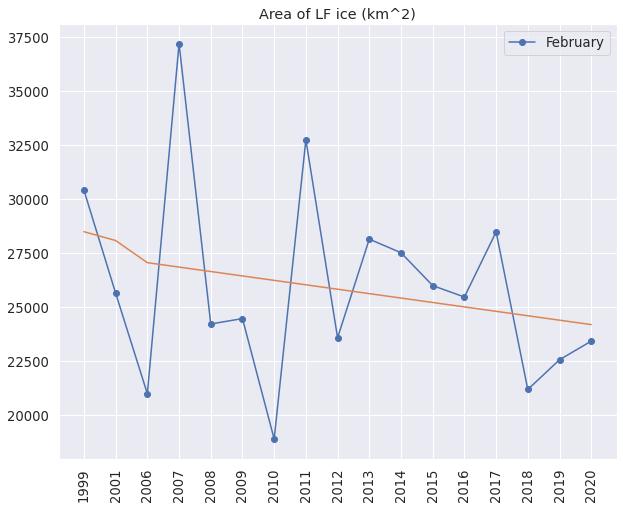

In [239]:
# Integrate d_km 

# Find distance between points

# Between inds 50 and -80 is between just north of lake melville opening and south of where data falls off for many years
u_km, v_km = deg2km(coastlat[150]-coastlat[-80],coastlon[150]-coastlon[-80])

DY = np.sqrt((u_km)**2 + (v_km)**2) 
dy = DY/len(coastlat[150:-2])

# 2001
# i = np.where(np.array(years_sina)==2001)[0][0]

LFA = np.zeros(len(years_sina))
for i in range(len(years_sina)):
    # LF ice area, km^2
    LFA[i] = sum(d_km[i,:])*dy
    
# Plot time series
# Subtract trend from mean to get anomolies
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
# Trendline
s,b = np.polyfit(years_sina,LFA,1)
plt.plot(LFA,'o-',label=mon_str[mon-1])
plt.plot(np.array(years_sina)*s + b)
plt.xticks(np.arange(0, len(d_km), 1.0))
xtick_labels = years_sina
ax.set_xticklabels(xtick_labels,rotation='vertical')
plt.legend()
plt.title('Area of LF ice (km^2)')

# Seasonal cycle for LF ice area

2019
2020
2020
2020
2020
2019
2014
8
9
10
11
2008


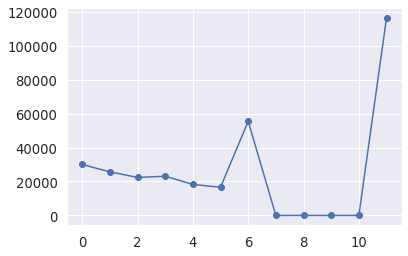

In [353]:
# Get all months

d_km = []
years_sina = []
ytrend = []
sinalat_red = [] 
sinalon_red = []
LFA = np.zeros(len(months_unique))


for mon in months_unique:
    D_KM, YEARS_SINA, YTREND, SINALAT_RED, SINALON_RED = dist_sina(mon,0)
#     d_km.append(D_KM)
#     years_sina.append(YEARS_SINA)
#     ytrend.append(YTREND)
    if len(D_KM) > 0:
        LFA[mon-1] = sum(D_KM[-1,:])*dy
        print(YEARS_SINA[-1])
    else:
        print(mon)
#     print(YEARS_SINA[-1])

plt.plot(LFA,'o-')